Copyright (c) OpenMMLab. All rights reserved.

Copyright (c) Meta Platforms, Inc. and affiliates.

Modified from https://colab.research.google.com/github/facebookresearch/mae/blob/main/demo/mae_visualize.ipynb

## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.

In [56]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

from mmselfsup.models import build_algorithm

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip install openmim
    !mim install mmcv-full
    !git clone https://github.com/open-mmlab/mmselfsup.git
    %cd mmselfsup/
    !pip install -e .
    sys.path.append('./mmselfsup')
    %cd demo
else:
    sys.path.append('..')

### Define utils

In [57]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    image = torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int()
    plt.imshow(image)
    plt.title(title, fontsize=16)
    plt.axis('off')
    return


def show_images(x, im_masked, y, im_paste):
    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 6]

    plt.subplot(1, 4, 1)
    show_image(x, "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked, "masked")

    plt.subplot(1, 4, 3)
    show_image(y, "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste, "reconstruction + visible")

    plt.show()


def post_process(x, y, mask):
    x = torch.einsum('nchw->nhwc', x.cpu())
    # masked image
    im_masked = x * (1 - mask)
    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask
    return x[0], im_masked[0], y[0], im_paste[0]

### Load an image

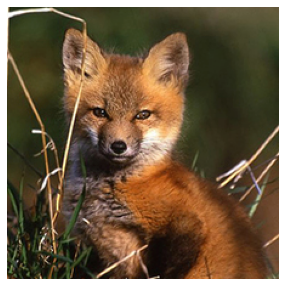

In [58]:
# load an image
img_url = 'https://download.openmmlab.com/mmselfsup/mae/fox.jpg'
img_pil = Image.open(requests.get(img_url, stream=True).raw)
img = img_pil.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

### Load a pre-trained MAE model

In [59]:
%%writefile ../configs/selfsup/mae/mae_visualization.py
model = dict(
    type='MAE',
    backbone=dict(type='MAEViT', arch='l', patch_size=16, mask_ratio=0.75),
    neck=dict(
        type='MAEPretrainDecoder',
        patch_size=16,
        in_chans=3,
        embed_dim=1024,
        decoder_embed_dim=512,
        decoder_depth=8,
        decoder_num_heads=16,
        mlp_ratio=4.,
    ),
    head=dict(type='MAEPretrainHead', norm_pix=True, patch_size=16))

img_norm_cfg = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# dataset summary
data = dict(
    test=dict(
        pipeline = [
            dict(type='Resize', size=(224, 224)),
            dict(type='ToTensor'),
            dict(type='Normalize', **img_norm_cfg),]
    ))

Overwriting ../configs/selfsup/mae/mae_visualization.py


In [60]:
# This is an MAE model trained with pixels as targets for visualization (ViT-large, training mask ratio=0.75)

# download checkpoint if not exist
# This ckpt is converted from https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth
!wget -nc https://download.openmmlab.com/mmselfsup/mae/mae_visualize_vit_large.pth

from mmselfsup.apis import init_model
ckpt_path = "mae_visualize_vit_large.pth"
model = init_model('../configs/selfsup/mae/mae_visualization.py', ckpt_path, device='cpu')
print('Model loaded.')

文件 “mae_visualize_vit_large.pth” 已经存在；不获取。

load checkpoint from local path: mae_visualize_vit_large.pth
Model loaded.


### Run MAE on the image

MAE with pixel reconstruction:


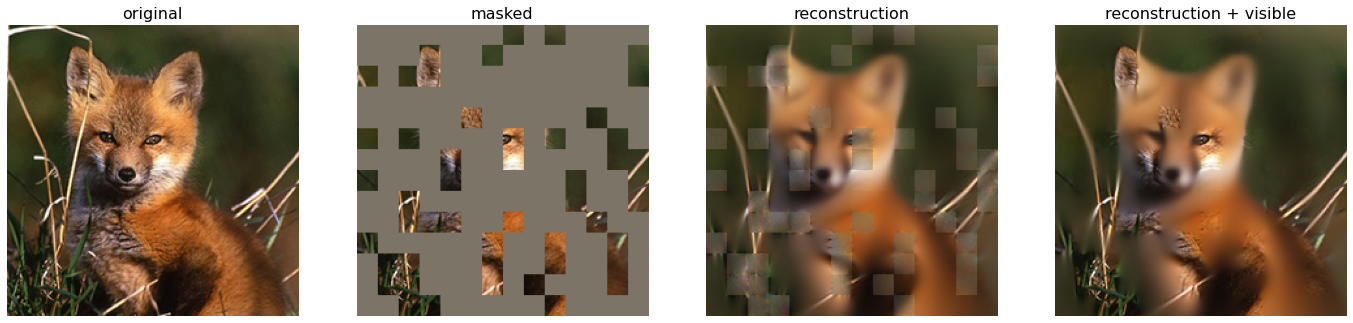

In [61]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')

from mmselfsup.apis import inference_model

img_url = 'https://download.openmmlab.com/mmselfsup/mae/fox.jpg'
img = Image.open(requests.get(img_url, stream=True).raw)
img, (mask, pred) = inference_model(model, img)
x, im_masked, y, im_paste = post_process(img, pred, mask)
show_images(x, im_masked, y, im_paste)